**Clasificador de sentimientos**

#Machine Learning classic (LogisticRegression)

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

##P0.descargando librerias

---
*   https://stackabuse.com/python-for-nlp-introduction-to-the-pattern-library/




In [ ]:
!pip install pyprind

In [ ]:
import nltk
nltk.download('stopwords') #Descargamos la lista de StopWord (pronombres, artículos, condicionales, demostrativos, adverbios de tiempo y lugar)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
!pip install pattern  #libreria para PLN (Tokenización, derivación, etiquetado de POS, análisis de sentimientos, etc)

     |████████████████████████████████| 22.2 MB 88.4 MB/s 
     |████████████████████████████████| 87 kB 6.2 MB/s 
     |████████████████████████████████| 81 kB 10.4 MB/s 
     |████████████████████████████████| 5.6 MB 45.4 MB/s 
     |████████████████████████████████| 5.6 MB 56.8 MB/s 
     |████████████████████████████████| 419 kB 47.4 MB/s 
     |████████████████████████████████| 104 kB 57.4 MB/s 
     |████████████████████████████████| 3.6 MB 38.8 MB/s 
  Created wheel for pattern: filename=Pattern-3.6-py3-none-any.whl size=22332721 sha256=773cee9ae872e668757eb698410ab2c1f26c5eb61e9be72ce1904ccc75d7485b
  Stored in directory: /root/.cache/pip/wheels/8d/1f/4e/9b67afd2430d55dee90bd57618dd7d899f1323e5852c465682
  Created wheel for mysqlclient: filename=mysqlclient-2.1.0-cp37-cp37m-linux_x86_64.whl size=99971 sha256=84612e19685ce120e7cecaf4219a0f412e71c4b1b3668ef269d76e6d32877c46
  Stored in directory: /root/.cache/pip/wheels/97/d4/df/08cd6e1fa4a8691b268ab254bd0fa589827ab5b65638c010b4


##P1.Importando librerias

###P1.1 Genericas

In [ ]:
import urllib.request
import numpy as np
import pandas as pd 
import os
import time
import sys
from zipfile import ZipFile       #para descomprimir ZIP
#-----librerias para trabajar PLN
import nltk
#from pattern.es import lemma
from nltk import word_tokenize
from nltk.corpus import stopwords

#----librerias para normalización de textos
import re
from unicodedata import normalize

###P1.2 Machine Learning

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

#CountVectorizer proporcionado por la biblioteca scikit-learn para vectorizar oraciones.
from sklearn.feature_extraction.text import CountVectorizer

##P2. descargando DataSet

In [ ]:
def reporthook(count, block_size, total_size):
    global start_time
    if count == 0:
        start_time = time.time()
        return
    duration = time.time() - start_time
    progress_size = int(count * block_size)
    speed = progress_size / (1024.**2 * duration)
    percent = count * block_size * 100. / total_size
    sys.stdout.write("\r%d%% | %d MB | %.2f MB/s | %d segundos transcurrido" %
                    (percent, progress_size / (1024.**2), speed, duration))
    sys.stdout.flush()

url_github_Model='https://github.com/luisFernandoCastellanosG/Machine_learning/blob/master/2-Deep_Learning/PLN/Datasets/DataSetOpiniones.zip?raw=true'
urllib.request.urlretrieve(url_github_Model,
                           'DataSetOpiniones.zip', 
                           reporthook)

105% | 0 MB | 4.07 MB/s | 0 segundos transcurrido

('DataSetOpiniones.zip', <http.client.HTTPMessage at 0x7f2cbf347550>)

##P3.descomprimir Zip y cargar en Dataframe

###P3.1 descomprimir ZIP

In [ ]:
test_file_name = "/content/DataSetOpiniones.zip"

with ZipFile(test_file_name, 'r') as zip:
    zip.printdir()
    zip.extractall('DataSetOpiniones') 

File Name                                             Modified             Size
yelp_labelledes.csv                            2018-10-28 20:00:56        68705
__MACOSX/                                      2018-10-28 20:41:30            0
__MACOSX/._yelp_labelledes.csv                 2018-10-28 20:00:56          323
amazon_cells_labelledes.csv                    2018-10-28 20:07:30        66148
__MACOSX/._amazon_cells_labelledes.csv         2018-10-28 20:07:30          323
imdb_labelledes.csv                            2018-10-28 20:20:24        93446
__MACOSX/._imdb_labelledes.csv                 2018-10-28 20:20:24          323


###P3.2 carga los CSV en Dataframe

In [ ]:
filepath_dict = {'yelp':   '/content/DataSetOpiniones/amazon_cells_labelledes.csv',
                 'amazon': '/content/DataSetOpiniones/amazon_cells_labelledes.csv',
                 'imdb':   '/content/DataSetOpiniones/imdb_labelledes.csv'}

df_list = []
for source, filepath in filepath_dict.items():
    df = pd.read_csv(filepath, names=['sentence', 'label'], sep='\t')
    df['source'] = source  # Add another column filled with the source name
    df_list.append(df)

df = pd.concat(df_list)
df.head(10)

,sentence,label,source
0,Así que no hay manera de que lo conecte aquí e...,0,yelp
1,"Buen caso, excelente valor.",1,yelp
2,Ideal para la quijada.,1,yelp
3,Atado al cargador para conversaciones que dura...,0,yelp
4,El micrófono es genial.,1,yelp
5,Tengo que mover el enchufe para alinearlo corr...,0,yelp
6,Si tiene varias docenas o varios cientos de co...,0,yelp
7,Si eres propietario de Razr ... debes tener esto!,1,yelp
8,No hace falta decir que desperdicié mi dinero.,0,yelp
9,¡Qué desperdicio de dinero y tiempo!.,0,yelp


##P4. conociendo la data (BagWord)

In [ ]:
print('RowsXcolums-->',df.shape)
print('yelp-->',sum(df['source'] == 'yelp'))
print('amazon-->',sum(df['source'] == 'amazon'))
print('imdb-->',sum(df['source'] == 'imdb'))

RowsXcolums--> (3000, 3)
yelp--> 1000
amazon--> 1000
imdb--> 1000


###P4.1 usando CountVectorizer (ejemplo)

---

CountVectorizer proporcionado por la biblioteca scikit-learn  realiza la tokenización que separa las oraciones en un conjunto de tokens ordenado por vocabulario. Además, elimina la puntuación y los caracteres especiales y puede aplicar otro preprocesamiento a cada palabra

In [ ]:
#obtener las palabras que aparecen de acuerdo con el Orden del vocabulario
oraciones = ['A Juan le gusta el chocolate', 'Juan odia el chocolate']
vectorizer = CountVectorizer(min_df=0, lowercase=True,stop_words=stopwords.words('spanish'))   
     
vectorizer.fit(oraciones)

CountVectorizer(min_df=0,
                stop_words=['de', 'la', 'que', 'el', 'en', 'y', 'a', 'los',
                            'del', 'se', 'las', 'por', 'un', 'para', 'con',
                            'no', 'una', 'su', 'al', 'lo', 'como', 'más',
                            'pero', 'sus', 'le', 'ya', 'o', 'este', 'sí',
                            'porque', ...])

In [ ]:
vectorizer.get_feature_names_out()

array(['chocolate', 'gusta', 'juan', 'odia'], dtype=object)

In [ ]:
vectorizer.vocabulary_

{'chocolate': 0, 'gusta': 1, 'juan': 2, 'odia': 3}

In [ ]:
#bolsa de palabras (Cada documento se representa como un vector)
#vectorizer.transform(oraciones).toarray()
array=vectorizer.transform(oraciones)
print(array.toarray())

[[1 1 1 0]
 [1 0 1 1]]


###P4.2 usando CountVectorizer con datos de YELP

In [ ]:
df_yelp = df[df['source'] == 'yelp']
sentences = df_yelp['sentence'].values
y = df_yelp['label'].values

sentences_train, sentences_test, y_train, y_test = train_test_split(
   sentences, y, test_size=0.25, random_state=1000)

###P4.3 generar BagWords 

---



In [ ]:
#generamos los vectores de palabras (750x1681) registrosXtamaño del vocabulario
#vectorizer = CountVectorizer(min_df=0, lowercase=True,stop_words=stopwords.words('spanish'))   
vectorizer = CountVectorizer(min_df=0, lowercase=True)   
vectorizer.fit(sentences_train)

X_train = vectorizer.transform(sentences_train)
X_test  = vectorizer.transform(sentences_test)
#print(X_train.toarray())

In [ ]:
print(X_train.toarray())
X_train.shape

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


(750, 1681)

##P5.modelo de ML (regresión logistica).

In [ ]:
classifier = LogisticRegression()
classifier.fit(X_train, y_train)
score = classifier.score(X_test, y_test)

print("Precisión:", score)

Precisión: 0.796


###P5.1 evaluando modelo por cada set de datos

In [ ]:
for source in df['source'].unique():
    df_source = df[df['source'] == source]
    sentences = df_source['sentence'].values
    y = df_source['label'].values
    sentences_train, sentences_test, y_train, y_test = train_test_split(
        sentences, y, test_size=0.25, random_state=1000)
    vectorizer = CountVectorizer(min_df=0, lowercase=True) 
    vectorizer.fit(sentences_train)
    X_train = vectorizer.transform(sentences_train)
    X_test  = vectorizer.transform(sentences_test)
    classifier = LogisticRegression()
    classifier.fit(X_train, y_train)
    score = classifier.score(X_test, y_test)
    print('Precisión para datos {}: {:.4f}'.format(source, score))

Precisión para datos yelp: 0.7960
Precisión para datos amazon: 0.7960
Precisión para datos imdb: 0.7720


###P5.2 evaluando modelo con fulldata

In [ ]:
sentences = df['sentence'].values
y = df['label'].values
sentences_train, sentences_test, y_train, y_test = train_test_split(
   sentences, y, test_size=0.25, random_state=1000)

vectorizer = CountVectorizer(min_df=0, lowercase=True)   
vectorizer.fit(sentences_train)

X_train = vectorizer.transform(sentences_train)
X_test  = vectorizer.transform(sentences_test)
modeloPLNRegLog = LogisticRegression()
modeloPLNRegLog.fit(X_train, y_train)
score = modeloPLNRegLog.score(X_test, y_test)

print("Precisión:", score)

Precisión: 0.8773333333333333


###P5.3 Salvando el modelo (serializando)

---
*   salvaremos el modelo y el vocabulario generado del bagWords
*   para ver metodos de exportación:
https://machinelearningmastery.com/save-load-machine-learning-models-python-scikit-learn/


In [ ]:
import pickle
#serializando el modelo
pickle.dump(modeloPLNRegLog, open( 'LogRegression_PLN_classSentimientos_model.sav', 'wb'))
#serializando el vocabulario
feature_list = vectorizer.get_feature_names_out()
pickle.dump(feature_list, open('vocabulary.pkl', 'wb'))

###P5.4 cargando el modelo (serializado)

In [ ]:
#cargando el modelo
modeloPLNRegLogNew = pickle.load(open('LogRegression_PLN_classSentimientos_model.sav', 'rb'))
#cargando el vocabulario
vocabularyNew= pickle.load(open('vocabulary.pkl', 'rb'))
vectorizerNew = CountVectorizer(min_df=0, lowercase=True,vocabulary = vocabularyNew)  #creando un nuevo vectorizador con el vocabulario cargado
result = modeloPLNRegLogNew.score(X_test, y_test)   #probado con el test de entrenamiento a ver si funciona
print('Inferencia:%',result)

Inferencia:% 0.8773333333333333


###P5.5 Haciendo predicciones

In [ ]:
oracion = ['estoy feliz con mi celular']
X_prueba = vectorizerNew.transform(oracion)  #convertimos la oración al array del bagword

#print('vector:',X_prueba[0].toarray())
predict=modeloPLNRegLogNew.predict(X_prueba)
print(oracion,', El sentimiento es :',predict)


['estoy feliz con mi celular'] , El sentimiento es : [1]


#Deep Learning

---
Donde usaremos Las redes neuronales, o algunas veces llamadas redes neuronales artificiales (RNA)
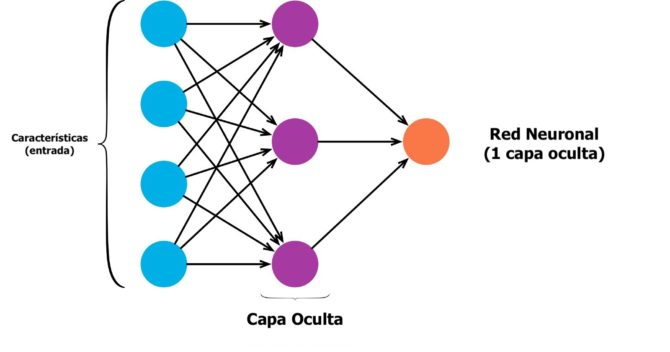


**Notas:**
*  la ultima capa es una sola neurona ya que el resultado es binario (1 o 0), pero si tiene varias categorías, debe usar varios neuronas para cada categoría.
*  Puede tener tantas capas ocultas como desee. De hecho, una red neuronal con más de una capa oculta se considera una red neuronal profunda.
*  el peso de cada neurona se calcula en el entrenamiento y comienza con la inicialización de los pesos con valores aleatorios y luego se entrenan con un método llamado backpropagation.
*   Esto se hace utilizando métodos de optimización como el descenso de gradiente para reducir el error entre la salida calculada y la deseada (también llamada salida objetivo)...el mejor es ADAM
*   Para calcular El error está determinado por una función de pérdida cuya pérdida queremos minimizar con el optimizador. en este tutorial solo necesitará la función de pérdida de entropía cruzada binaria que se usa para los problemas de clasificación binaria.


##Usando KERAS

---

Usaremos un modelo secuencial que es una pila lineal de capas, donde puede usar la gran variedad de capas disponibles en Keras. La capa más común es la capa Densa, que es su capa de red neuronal densamente conectada con todos los pesos y sesgos con los que ya está familiarizado

##P0.importando librerias

In [ ]:
from keras.models import Sequential
from keras import layers

##P1.Creando modelo secuencial

---
*  1° capa tendremos doble capa 
*   - 1° # dimensiones (4085 columnas)
*   - 2° 10 neuronas
*   usaremos como activación RELU/Sigmoidal

In [ ]:
input_dim = X_train.shape[1]  # Numero de características (neuronas de entrada)
print("neuronas de entrada (columnas del vector de entrenamiento):",input_dim)

neuronas de entrada (columnas del vector de entrenamiento): 4085


In [ ]:
model = Sequential()
model.add(layers.Dense(10, input_dim=input_dim, activation='relu')) #1° # dimensiones (4085 columnas), 2° 10 neuronas
model.add(layers.Dense(10, input_dim=input_dim, activation='relu'))  #que pasa si agregamos otra capa (mejorara?)
model.add(layers.Dense(1, activation='sigmoid'))

##P2. compilando el modelo.

---
Antes de que pueda comenzar con el entrenamiento del modelo, debe configurar el proceso de aprendizaje. Esto se hace con el método .compile().
*   Este método especifica el optimizador y la función de pérdida
*   agregamos una lista de métricas que luego se pueden usar para la evaluación (accuracy o Loss)


In [ ]:
model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 10)                40860     
                                                                 
 dense_6 (Dense)             (None, 10)                110       
                                                                 
 dense_7 (Dense)             (None, 1)                 11        
                                                                 
Total params: 40,981
Trainable params: 40,981
Non-trainable params: 0
_________________________________________________________________


##P3. entrenamos el modelo

In [ ]:
history = model.fit(X_train, y_train,
                    epochs=500,
                    verbose=True,
                    validation_data=(X_test, y_test),
                    batch_size=10)

Epoch 1/500
225/225 [==============================] - 1s 3ms/step - loss: 0.0163 - accuracy: 0.9964 - val_loss: 0.3377 - val_accuracy: 0.9000
Epoch 2/500
225/225 [==============================] - 1s 4ms/step - loss: 0.0128 - accuracy: 0.9969 - val_loss: 0.3584 - val_accuracy: 0.8947
Epoch 3/500
225/225 [==============================] - 1s 5ms/step - loss: 0.0093 - accuracy: 0.9973 - val_loss: 0.3749 - val_accuracy: 0.8947
Epoch 4/500
225/225 [==============================] - 1s 4ms/step - loss: 0.0084 - accuracy: 0.9978 - val_loss: 0.3888 - val_accuracy: 0.8907
Epoch 5/500
225/225 [==============================] - 1s 4ms/step - loss: 0.0066 - accuracy: 0.9978 - val_loss: 0.4323 - val_accuracy: 0.8880
Epoch 6/500
225/225 [==============================] - 1s 3ms/step - loss: 0.0072 - accuracy: 0.9978 - val_loss: 0.4593 - val_accuracy: 0.8853
Epoch 7/500
225/225 [==============================] - 1s 2ms/step - loss: 0.0070 - accuracy: 0.9982 - val_loss: 0.4329 - val_accuracy: 0.8880

##P4. viendo grafica de entrenamiento

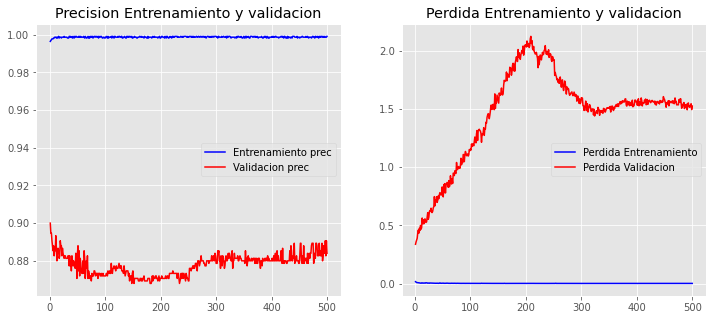

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('ggplot') # 

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Entrenamiento prec')
    plt.plot(x, val_acc, 'r', label='Validacion prec')
    plt.title('Precision Entrenamiento y validacion')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Perdida Entrenamiento')
    plt.plot(x, val_loss, 'r', label='Perdida Validacion')
    plt.title('Perdida Entrenamiento y validacion')
    plt.legend()
    plt.show()

plot_history(history)

##P5.evaluar el modelo (presición)

In [ ]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Precisión Entrenamiento: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Precisión Prueba:  {:.4f}".format(accuracy))

Precisión Entrenamiento: 0.9991
Precisión Prueba:  0.8840


##P6. haciendo predicciones

In [ ]:
oracion = ['estoy feliz con mi celular']
X_prueba = vectorizerNew.transform(oracion)  #convertimos la oración al array del bagword

#print('vector:',X_prueba[0].toarray())
predict=model.predict(X_prueba)
print(oracion,', El sentimiento es :',predict)

['estoy feliz con mi celular'] , El sentimiento es : [[1.]]


##P7. Exportar modelo y vocabulario


In [ ]:
model.save('PLN_SENTIMIENTOS.h5');